Find the directivity of an array with four ULA isotropic radiators. Plot the max broadside directivity as a function of the element spacing over the range $0 \leq d \leq 3\lambda$.

Overlay the directivity obtained with the conjugate field match solution.

$$ D = N*D_{el} $$

How to do the max directivity element excitation currents behave for very small element spacings.

Step 1: Find the overlap matrix

$$ A_{mn} = P_{rad}\frac{\sin(kr_{mn})}{kr_{mn}} $$

Step 2: Find $E_p(r)$

$$ E_0 = \sqrt{\frac{2\eta P_{rad}}{4\pi r^2}} $$
$$ E_p = E_0 * [1, 1, 1, 1]^T $$

Step 3: Find the weights

$$ w = A^{-1}E_p(r) $$

Step 4: Find the maximum directivity

$$ D(\Omega)=\frac{4\pi r^2 w^H B w}{w^H A w} $$

/tmp/ipykernel_439/4194187914.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  B[m, n] = E0*np.exp(1j*k*rx[m]) * E0*np.exp(1j*k*rx[n]).conj() / (2*eta)


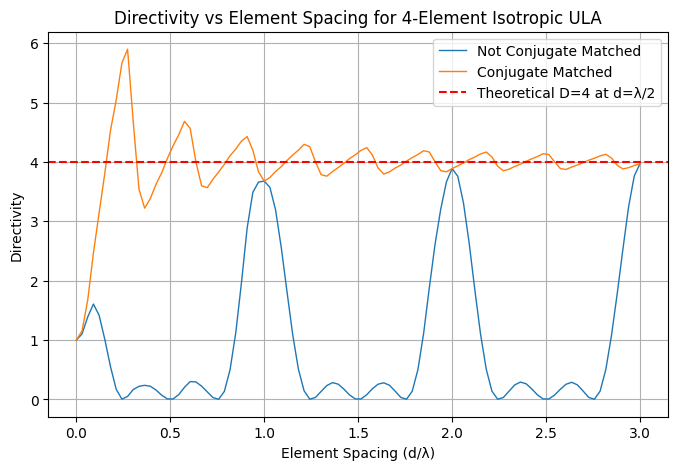

In [61]:
import numpy as np
import matplotlib.pyplot as plt

#### VARIABLES ####
# Define antenna parameters
f = 1e9          # Frequency in Hz
c = 3e8          # Speed of light in m/s
lam = c / f      # Wavelength in m
k = 2 * np.pi / lam  # Wave number
eta = 377        # Intrinsic impedance of free space
Pel = 1          # Radiated power
r = 1            # Observation distance

# Define element spacing range
num_points = 100
d_values = np.linspace(0, 3*lam, num_points)  # Range of element spacings

# Number of elements in the array
N = 4

# Electric field calculation
E0 = np.sqrt(2*eta*Pel/(4*np.pi*r**2))

# conjugate matched weights
Ep = E0*np.ones((N, 1))
w_cm = Ep

# empty array of directivity values
directivity_values = []
directivity_values_cm = []





#### FUNCTIONS ####
def compute_overlap(rx, k):
    # Compute overlap matrix A
    A = np.zeros((N, N))
    for m in range(N):
        for n in range(N):
            r_mn = abs(rx[m] - rx[n])  # Distance between elements
            A[m, n] = np.sinc(k * r_mn)  # Corrected sinc function
    #print("Overlap Matrix \n", A)
    return A

def compute_weights(A, E_in):
    # compute E-fields at each element
    E = np.zeros((N,1))
    for n in range(N):
        E[n] = E_in*np.exp(1j*k*rx[n])

    A_inv = np.linalg.pinv(A)   # invert overlap
    w = np.dot(A_inv, E)        # Compute weights
    #print("weights \n", w)
    return w

def compute_signal_response(E0):
    # calculate the signal response
    B = np.zeros((N, N))
    for m in range(N):
        for n in range(N):
            r_mn = abs(rx[m] - rx[n])  # Distance between elements
            B[m, n] = E0*np.exp(1j*k*rx[m]) * E0*np.exp(1j*k*rx[n]).conj() / (2*eta)
    #print("Signal Respone \n", B)
    return B

def compute_signal_response_p(Ep):
    Bp = Ep * Ep.conj().T / (2*eta)
    #print("Signal Respone \n", Bp)
    return Bp

def compute_directivity(r,w,B,A):
    # Compute Directivity
    w_herm = w.conj().T
    #print("hermitian of weights \n", w_herm)
    scalar = 4 * np.pi * (r**2)
    num_1 = np.dot(w_herm, B)
    num_2 = np.dot(num_1, w)
    den_1 = np.dot(w_herm, A)
    den_2 = np.dot(den_1, w)
    D = scalar * num_2 / den_2
    #print("Directivity \n", D)
    return D




#### CALCULATIONS ####
for d in d_values:
    # Define the receiver positions
    rx = np.array([n * d for n in range(N)])  # Positions of elements
    
    # Compute overlap matrix A
    A = compute_overlap(rx, k)

    # Compute weights
    #w = compute_weights(A, E0)
    w = np.array([[1,1,1,1],
                  [1,1,1,1],
                  [1,1,1,1],
                  [1,1,1,1]])

    # compute B
    B = compute_signal_response(E0)

    # compute Bp
    Bp = compute_signal_response_p(Ep)

    # compute directivity
    D = compute_directivity(r, w, B, A)
    D_cm = compute_directivity(r, w_cm, Bp, A)


    directivity_values.append(D[0,0])
    directivity_values_cm.append(D_cm[0,0])





#### PLOTS ####
plt.figure(figsize=(8, 5))
plt.plot(d_values / lam, directivity_values, label="Not Conjugate Matched", linewidth=1)
plt.plot(d_values / lam, directivity_values_cm, label="Conjugate Matched", linewidth=1)
plt.axhline(y=N, color='r', linestyle='--', label="Theoretical D=4 at d=λ/2")  # Reference line at 4
plt.xlabel("Element Spacing (d/λ)")
plt.ylabel("Directivity")
plt.title("Directivity vs Element Spacing for 4-Element Isotropic ULA")
plt.grid(True)
plt.legend()
plt.show()

Plot the pattern steered to endfire.

Repeat 4.8 for a uniform linear array of parallel half wave dipoles with the sinusoidalcurrent model using the LRMSA method.

1. Select the antenna element and find the isolated element pattern for an open circuit load. 

Find the electric field of a single dipole then put it into:

$$ E_n(r) = E_{el}(r)e^{jkrr_n} $$

2. Compute the pattern overlap matrix using analytical integration if possible for simple element types, or using numerical integrate.

$$ A_{mn} = \frac{1}{2\eta} \int E_m E_n^* r^2 d\Omega $$

3. Approximate the mutual impedance matrix using the pattern overlap matric using

$$ Z_a = \frac{2}{|I_0|^2}A $$

In [53]:
# for a dipole

#### Variables ####
# Define antenna parameters
f = 1e9          # Frequency in Hz
c = 3e8          # Speed of light in m/s
lam = c / f      # Wavelength in m
k = 2 * np.pi / lam  # Wave number
eta = 377        # Intrinsic impedance of free space
Pel = 1          # Radiated power
r = 1            # Observation distance

# Define element spacing range
num_points = 100
d_values = np.linspace(0, 3*lam, num_points)  # Range of element spacings

# Number of elements in the array
N = 4

# Electric field calculation
E = np.sqrt(2*eta*Pel/(4*np.pi*r**2))
Ep = E*np.ones((N, 1))

# conjugate matched weights
w_cm = Ep

# empty array of directivity values
directivity_values = []
directivity_values_cm = []

#### STEPS ####
# step 1
l = lam /2
Im = 1
theta = np.pi/2

Sr = eta*Im*2 * np.cos(np.pi*np.cos(theta)/2)**2 / (8*np.pi**2 * r**2 * np.sin(theta)**2)
print("Power Density", Sr)

# step 2
# Compute overlap matrix A
def overlap_dipole(rx, k):
    A = np.zeros((N, N))
    for m in range(N):
        for n in range(N):
            r_mn = abs(rx[m] - rx[n])  # Distance between elements
            A[m, n] = Sr * 3*r_mn**2   # Overlap matrix element  
    print("Overlap Matrix \n", A)


for d in d_values:
    # Define the receiver positions
    rx = np.array([n * d for n in range(N)])  # Positions of elements
    
    # Compute overlap matrix A
    A = overlap_dipole(rx, k)

    # Step 3
    Za = 2 / (np.abs(Im)**2) * A
    print("Impedance Matrix", Za)

    # Compute weights
    w = compute_weights(Za, Ep)

    # compute B
    B = compute_B(Ep)

    # compute directivity
    D = compute_directivity(r, w, B, Za)
    D_cm = compute_directivity(r, w_cm, B, Za)


    directivity_values.append(D[0,0])
    directivity_values_cm.append(D_cm[0,0])
    
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(d_values / lam, directivity_values, label="Computed Directivity", linewidth=1)
plt.plot(d_values / lam, directivity_values_cm, label="Computed Directivity", linewidth=1)
plt.axhline(y=N, color='r', linestyle='--', label="Theoretical D=4 at d=λ/2")  # Reference line at 4
plt.xlabel("Element Spacing (d/λ)")
plt.ylabel("Directivity")
plt.title("Directivity vs Element Spacing for 4-Element ULA")
plt.grid(True)
plt.legend()
plt.show()

Power Density 9.549521558290335
Overlap Matrix 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'